## 필요 모듈 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

### GPU 확인

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [37]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

### feature정보 확인

In [34]:
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


### 데이터 개수 확인

In [35]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


### 255로 정규화(normalize)

In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### label 및 image 확인

In [8]:
ds_info.features["label"].num_classes

10

In [9]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

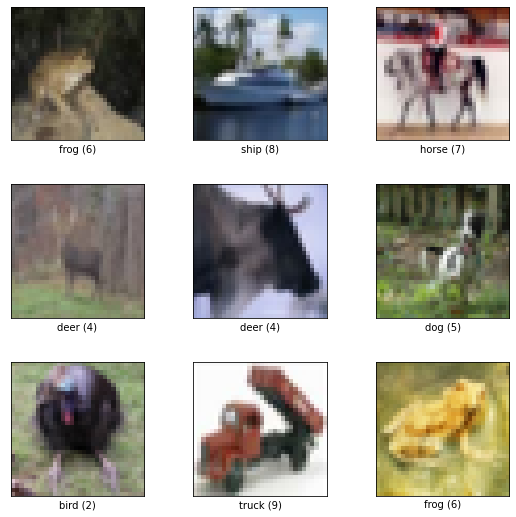

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

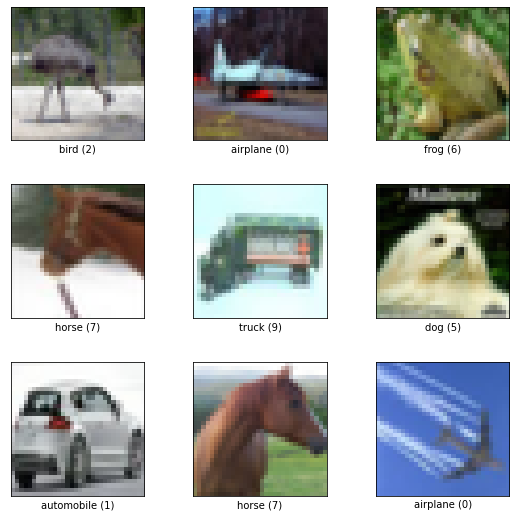

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

## ResNet 기본 블록 만들기

In [15]:
# function for building ResNet Block

def build_res_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [16]:
res_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
res_block_output = build_res_block(res_input_layer)    # res 블록 생성

In [17]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=res_input_layer, outputs=res_block_output)  

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


## ResNet 만들기

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.python.keras.applications import imagenet_utils

# CIFAR100 데이터셋을 가져옵시다. 
cifar100 = keras.datasets.cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

print(len(x_train), len(x_test))

50000 10000


In [39]:
img_input = keras.Input(shape=(32, 32, 3))

x = keras.layers.Conv2D(16, 3, activation='relu')(img_input)
x = keras.layers.MaxPool2D((2,2))(x)
x = keras.layers.Conv2D(32, 3, activation='relu')(x)
x = keras.layers.MaxPool2D((2,2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
predictions = keras.layers.Dense(100, activation='softmax')(x)

model = keras.Model(inputs=img_input, outputs=predictions)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2951

In [40]:
# 추가로 import해야 할 패키지들을 먼저 가져옵니다. 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.keras import backend
from tensorflow.python.keras import initializers
from tensorflow.python.keras import layers
from tensorflow.python.keras import models
from tensorflow.python.keras import regularizers


# block 안에 반복적으로 활용되는 L2 regularizer를 선언해 줍니다.
def _gen_l2_regularizer(use_l2_regularizer=True, l2_weight_decay=1e-4):
  return regularizers.l2(l2_weight_decay) if use_l2_regularizer else None

In [41]:
L2_WEIGHT_DECAY = 1e-4
BATCH_NORM_DECAY = 0.9
BATCH_NORM_EPSILON = 1e-5

In [42]:
def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2),
               use_l2_regularizer=True,
               batch_norm_decay=0.9,
               batch_norm_epsilon=1e-5):
  """A block that has a conv layer at shortcut.
  Note that from stage 3,
  the second conv layer at main path is with strides=(2, 2)
  And the shortcut should have strides=(2, 2) as well
  Args:
    input_tensor: input tensor
    kernel_size: default 3, the kernel size of middle conv layer at main path
    filters: list of integers, the filters of 3 conv layer at main path
    stage: integer, current stage label, used for generating layer names
    block: 'a','b'..., current block label, used for generating layer names
    strides: Strides for the second conv layer in the block.
    use_l2_regularizer: whether to use L2 regularizer on Conv layer.
    batch_norm_decay: Moment of batch norm layers.
    batch_norm_epsilon: Epsilon of batch borm layers.
  Returns:
    Output tensor for the block.
  """
  filters1, filters2, filters3 = filters
  if backend.image_data_format() == 'channels_last':
    bn_axis = 3
  else:
    bn_axis = 1
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  x = layers.Conv2D(
      filters1, (1, 1),
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2a')(
          input_tensor)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2a')(
          x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(
      filters2,
      kernel_size,
      strides=strides,
      padding='same',
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2b')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2b')(
          x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(
      filters3, (1, 1),
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2c')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2c')(
          x)

  shortcut = layers.Conv2D(
      filters3, (1, 1),
      strides=strides,
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '1')(
          input_tensor)
  shortcut = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '1')(
          shortcut)

  x = layers.add([x, shortcut])
  x = layers.Activation('relu')(x)
  return x

In [43]:
def identity_block(input_tensor,
                   kernel_size,
                   filters,
                   stage,
                   block,
                   use_l2_regularizer=True):
  """The identity block is the block that has no conv layer at shortcut.

  Args:
    input_tensor: input tensor
    kernel_size: default 3, the kernel size of middle conv layer at main path
    filters: list of integers, the filters of 3 conv layer at main path
    stage: integer, current stage label, used for generating layer names
    block: 'a','b'..., current block label, used for generating layer names
    use_l2_regularizer: whether to use L2 regularizer on Conv layer.

  Returns:
    Output tensor for the block.
  """
  filters1, filters2, filters3 = filters
  if backend.image_data_format() == 'channels_last':
    bn_axis = 3
  else:
    bn_axis = 1
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  x = layers.Conv2D(
      filters1, (1, 1),
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2a')(
          input_tensor)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=BATCH_NORM_DECAY,
      epsilon=BATCH_NORM_EPSILON,
      name=bn_name_base + '2a')(
          x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(
      filters2,
      kernel_size,
      padding='same',
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2b')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=BATCH_NORM_DECAY,
      epsilon=BATCH_NORM_EPSILON,
      name=bn_name_base + '2b')(
          x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(
      filters3, (1, 1),
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2c')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=BATCH_NORM_DECAY,
      epsilon=BATCH_NORM_EPSILON,
      name=bn_name_base + '2c')(
          x)

  x = layers.add([x, input_tensor])
  x = layers.Activation('relu')(x)
  return x

In [44]:
def resnet50(num_classes,
             batch_size=None,
             use_l2_regularizer=True):
  """Instantiates the ResNet50 architecture.

  Args:
    num_classes: `int` number of classes for image classification.
    batch_size: Size of the batches for each step.
    use_l2_regularizer: whether to use L2 regularizer on Conv/Dense layer.

  Returns:
      A Keras model instance.
  """
  input_shape = (32, 32, 3)
  img_input = layers.Input(shape=input_shape, batch_size=batch_size)

  if backend.image_data_format() == 'channels_first':
    x = layers.Lambda(
        lambda x: backend.permute_dimensions(x, (0, 3, 1, 2)),
        name='transpose')(
            img_input)
    bn_axis = 1
  else:  # channels_last
    x = img_input
    bn_axis = 3

  x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(x)
  x = layers.Conv2D(
      64, (7, 7),
      strides=(2, 2),
      padding='valid',
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name='conv1')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=BATCH_NORM_DECAY,
      epsilon=BATCH_NORM_EPSILON,
      name='bn_conv1')(
          x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

  x = conv_block(
      x,
      3, [64, 64, 256],
      stage=2,
      block='a',
      strides=(1, 1),
      use_l2_regularizer=use_l2_regularizer)
  x = identity_block(
      x,
      3, [64, 64, 256],
      stage=2,
      block='b',
      use_l2_regularizer=use_l2_regularizer)
  x = identity_block(
      x,
      3, [64, 64, 256],
      stage=2,
      block='c',
      use_l2_regularizer=use_l2_regularizer)

  x = conv_block(
      x,
      3, [128, 128, 512],
      stage=3,
      block='a',
      use_l2_regularizer=use_l2_regularizer)
  x = identity_block(
      x,
      3, [128, 128, 512],
      stage=3,
      block='b',
      use_l2_regularizer=use_l2_regularizer)
  x = identity_block(
      x,
      3, [128, 128, 512],
      stage=3,
      block='c',
      use_l2_regularizer=use_l2_regularizer)
  x = identity_block(
      x,
      3, [128, 128, 512],
      stage=3,
      block='d',
      use_l2_regularizer=use_l2_regularizer)

  x = conv_block(
      x,
      3, [256, 256, 1024],
      stage=4,
      block='a',
      use_l2_regularizer=use_l2_regularizer)
  x = identity_block(
      x,
      3, [256, 256, 1024],
      stage=4,
      block='b',
      use_l2_regularizer=use_l2_regularizer)
  x = identity_block(
      x,
      3, [256, 256, 1024],
      stage=4,
      block='c',
      use_l2_regularizer=use_l2_regularizer)
  x = identity_block(
      x,
      3, [256, 256, 1024],
      stage=4,
      block='d',
      use_l2_regularizer=use_l2_regularizer)
  x = identity_block(
      x,
      3, [256, 256, 1024],
      stage=4,
      block='e',
      use_l2_regularizer=use_l2_regularizer)
  x = identity_block(
      x,
      3, [256, 256, 1024],
      stage=4,
      block='f',
      use_l2_regularizer=use_l2_regularizer)

  x = conv_block(
      x,
      3, [512, 512, 2048],
      stage=5,
      block='a',
      use_l2_regularizer=use_l2_regularizer)
  x = identity_block(
      x,
      3, [512, 512, 2048],
      stage=5,
      block='b',
      use_l2_regularizer=use_l2_regularizer)
  x = identity_block(
      x,
      3, [512, 512, 2048],
      stage=5,
      block='c',
      use_l2_regularizer=use_l2_regularizer)

  rm_axes = [1, 2] if backend.image_data_format() == 'channels_last' else [2, 3]
  x = layers.Lambda(lambda x: backend.mean(x, rm_axes), name='reduce_mean')(x)
  x = layers.Dense(
      num_classes,
      kernel_initializer=initializers.RandomNormal(stddev=0.01),
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      bias_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name='fc1000')(
          x)

  # A softmax that is followed by the model loss must be done cannot be done
  # in float16 due to numeric issues. So we pass dtype=float32.
  x = layers.Activation('softmax', dtype='float32')(x)

  # Create model.
  return models.Model(img_input, x, name='resnet50')

In [45]:
model = resnet50(num_classes=100)

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9408        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

## 모델 학습

In [46]:
# 모델 학습!! 
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=40)

Epoch 1/40
1563/1563 [==============================] - 118s 75ms/step - loss: 8.0396 - accuracy: 0.0876
Epoch 2/40
1563/1563 [==============================] - 58s 37ms/step - loss: 5.5441 - accuracy: 0.1489
Epoch 3/40
1563/1563 [==============================] - 55s 35ms/step - loss: 4.8810 - accuracy: 0.1662
Epoch 4/40
1563/1563 [==============================] - 55s 35ms/step - loss: 4.3324 - accuracy: 0.2195
Epoch 5/40
1563/1563 [==============================] - 64s 41ms/step - loss: 4.1790 - accuracy: 0.2417
Epoch 6/40
1563/1563 [==============================] - 66s 43ms/step - loss: 3.8305 - accuracy: 0.2844
Epoch 7/40
1563/1563 [==============================] - 67s 43ms/step - loss: 3.5727 - accuracy: 0.3204
Epoch 8/40
1563/1563 [==============================] - 68s 43ms/step - loss: 3.4165 - accuracy: 0.3447
Epoch 9/40
1563/1563 [==============================] - 68s 43ms/step - loss: 3.1565 - accuracy: 0.3808
Epoch 10/40
1563/1563 [==============================] - 68s 43